In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import pandas as pd
import seaborn
from numpy.linalg import inv

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# from mpl_toolkits.basemap import basemap

In [2]:
#Typical correlation function

def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

In [3]:
#Load Data
n34 = xr.open_dataset('n34T.nc')
n34 = n34-n34.n34[0:360].mean('T')

hdpd = pd.read_csv('points_with_gridIds_reLabel_year.csv')
hd = pd.DataFrame.to_xarray(hdpd)

#Switch Longitutde to Degrees East

hd['Lon'] = -1*hd['Lon']
hdpd['Lon'] = -1*hdpd['Lon']

In [4]:
#Get a list of all keys to easily access each storm

allkeys = hd.groupby('key').count().key.values

In [5]:
#create a pandas dataframe and fill it with data for each storm:
#Year, did it become hurricane? Y/N, did it make landfall? Y/N, max wind speed, minimum atm. pressure, and unique key

biglist = pd.DataFrame(columns = ['Year', 'Hurr', 'Landfall', 'MaxSpeed', 'MinPres', 'key'], index = np.arange(0,len(allkeys)))

for key in range(len(allkeys)):
    
    #initialize values
    maxspeed = 0
    minpres = 99999
    year = allkeys[key][-4:]
    minTemp = 1000
    landfall = False
    hurr = False
    thisHurr = hd.where(hd['key'] == allkeys[key], drop = True)
    
    #Get whether landfall
    for i in thisHurr['SST']:
        if i < minTemp:
            minTemp = i
    if minTemp == 0:
        landfall = True
        
    #Get max wind
    for j in thisHurr['Max wind']:
        if j.values > maxspeed:
            maxspeed = j.values
            
    #Get min pres
    for k in thisHurr['Min pres']:
        if k.values < minpres:
            minpres = k.values
            
    #WasHurr?
    for l in thisHurr['Class']:
        if l.values == ' HU':
            hurr = True
    #Add to list
    biglist.loc[key] = [year, hurr, landfall, maxspeed, minpres, allkeys[key]]

In [6]:

#empty list 
yearcount = []
# xar = xr.DataArray(biglist)

#Sort list and re-index
inOrder = biglist.sort_values('Year')
inOrder.index = np.arange(0,len(allkeys))

speedbins = (inOrder.MaxSpeed.min()-1, inOrder.MaxSpeed.mean(), inOrder.MaxSpeed.max()+1)
# speedbins

#define some quantiles for max wind speed
speedQuant = np.quantile(inOrder.MaxSpeed, [0.2, 0.8])

#individual yearly values for reg.
years = np.arange(1982, 2020)
for i in years:
    thisYearFalls = 0
    thisYearTot = 0
    thisYearFast = 0
    thisYearPres = 1100
    thisYearHurr = 0
    sLow = 0
    sMed = 0
    sHigh = 0
    for j in range(len(inOrder)):
        
        #Check this year
        if inOrder.Year[j] == str(i):
            thisYearTot += 1
            
            s = inOrder.MaxSpeed[j]
            
            #add up landfall count
            if inOrder.Landfall[j] != False:
                thisYearFalls += 1
                
            #Get max wind speed
            if s > thisYearFast:
                thisYearFast = inOrder.MaxSpeed[j]
                
            #Speed bins, return one's proportion
            if s < speedQuant[0]:
                sLow += 1
            elif s > speedQuant[1]:
                sHigh += 1
            else:
                sMed += 1
                
                
            #Get min press
            if inOrder.MinPres[j] < thisYearPres and inOrder.MinPres[j] > 0:
                thisYearPres = inOrder.MinPres[j]
                
            #Add up hurricane count
            if inOrder.Hurr[j] != False:
                thisYearHurr += 1               
            
                
    #Put data in list
    yearcount.append([i, sHigh/(sLow+sMed+sHigh), thisYearHurr / thisYearTot, thisYearFast, thisYearPres, thisYearFalls, thisYearFalls / thisYearTot, thisYearTot])
    
#Create df with list data
resF = pd.DataFrame(yearcount, columns = ['Year', 'PropSev', 'PropHurr', 'MaxSpeed', 'MinPress', 'NumLand', 'Prop', 'Count'])

In [7]:
#This may be unnecessary

n34 = xr.open_dataset('n34T.nc')
n34 = n34-n34.n34[0:360].mean('T')
# for i in np.arange(1,13):
#     for j in n34.n34:
#         if j['T'].dt.month == i:
#             j.T.values -= n34.n34.where(n34['T'].dt.month == i, drop = True).mean('T')
Jan = 1
Feb = 2
Mar = 3
Apr = 4
May = 5
Jun = 6
Jul = 7
Aug = 8
Sep = 9
Oct = 10
Nov = 11
Dec = 12
n34_Jan = n34.n34.where(n34['T'].dt.month == Jan, drop = True)
n34_Feb = n34.n34.where(n34['T'].dt.month == Feb, drop = True)
n34_Mar = n34.n34.where(n34['T'].dt.month == Mar, drop = True)
n34_Apr = n34.n34.where(n34['T'].dt.month == Apr, drop = True)
n34_May = n34.n34.where(n34['T'].dt.month == May, drop = True)
n34_Jun = n34.n34.where(n34['T'].dt.month == Jun, drop = True)
n34_Jul = n34.n34.where(n34['T'].dt.month == Jul, drop = True)
n34_Aug = n34.n34.where(n34['T'].dt.month == Aug, drop = True)
n34_Sep = n34.n34.where(n34['T'].dt.month == Sep, drop = True)
n34_Oct = n34.n34.where(n34['T'].dt.month == Oct, drop = True)
n34_Nov = n34.n34.where(n34['T'].dt.month == Nov, drop = True)
n34_Dec = n34.n34.where(n34['T'].dt.month == Dec, drop = True)

In [8]:
resF['n34_Aug'] = n34_Aug[2:-1]
resF['n34_Sep'] = n34_Sep[2:-1]
resF['n34_Jan'] = n34_Jan[2:-1]
resF['n34_Feb'] = n34_Feb[2:-1]
resF['n34_Mar'] = n34_Mar[2:-1]
resF['n34_Apr'] = n34_Apr[2:-1]
resF['n34_May'] = n34_May[2:-1]
resF['n34_Jun'] = n34_Jun[2:-1]
resF['n34_Jul'] = n34_Jul[2:-1]
resF['n34_Oct'] = n34_Oct[2:-1]
resF['n34_Nov'] = n34_Nov[2:]
resF['n34_Dec'] = n34_Dec[2:]

lowc = .2
highc = .8
e = [lowc, highc]
#quantiles
vals1 = np.quantile(resF['n34_Jan'], e)
vals2 = np.quantile(resF['n34_Feb'], e)
vals3 = np.quantile(resF['n34_Mar'], e)
vals4 = np.quantile(resF['n34_Apr'], e)
vals5 = np.quantile(resF['n34_May'], e)
vals6 = np.quantile(resF['n34_Jun'], e)
vals7 = np.quantile(resF['n34_Jul'], e)
vals8 = np.quantile(resF['n34_Aug'], e)
vals9 = np.quantile(resF['n34_Sep'], e)
vals10 = np.quantile(resF['n34_Oct'], e)
vals11 = np.quantile(resF['n34_Nov'], e)
vals12 = np.quantile(resF['n34_Dec'], e)

# if resF['n34_Aug'] > vals[1]:
#     resF['Aug_Nino'] = 'Above'
# elif resF['n34_Aug'] < vals[0]:
#     resF['Aug_Nino'] = 'below'
# else:
#     resF['Aug_Nino'] = 'neutral'
resF['Aug_Nino'] = resF['n34_Aug'] > vals8[1]
resF['Aug_Nina'] = resF['n34_Aug'] < vals8[0]
resF['Jan_Nino'] = resF['n34_Jan'] > vals1[1]
resF['Jan_Nina'] = resF['n34_Jan'] < vals1[0]
resF['Feb_Nino'] = resF['n34_Feb'] > vals2[1]
resF['Feb_Nina'] = resF['n34_Feb'] < vals2[0]
resF['Mar_Nino'] = resF['n34_Mar'] > vals3[1]
resF['Mar_Nina'] = resF['n34_Mar'] < vals3[0]
resF['Apr_Nino'] = resF['n34_Apr'] > vals4[1]
resF['Apr_Nina'] = resF['n34_Apr'] < vals4[0]
resF['May_Nino'] = resF['n34_May'] > vals5[1]
resF['May_Nina'] = resF['n34_May'] < vals5[0]
resF['Jun_Nino'] = resF['n34_Jun'] > vals6[1]
resF['Jun_Nina'] = resF['n34_Jun'] < vals6[0]
resF['Jul_Nino'] = resF['n34_Jul'] > vals7[1]
resF['Jul_Nina'] = resF['n34_Jul'] < vals7[0]
resF['Sep_Nino'] = resF['n34_Sep'] > vals9[1]
resF['Sep_Nina'] = resF['n34_Sep'] < vals9[0]
resF['Oct_Nino'] = resF['n34_Oct'] > vals10[1]
resF['Oct_Nina'] = resF['n34_Oct'] < vals10[0]
resF['Nov_Nino'] = resF['n34_Nov'] > vals11[1]
resF['Nov_Nina'] = resF['n34_Nov'] < vals11[0]
resF['Dec_Nino'] = resF['n34_Dec'] > vals12[1]
resF['Dec_Nina'] = resF['n34_Dec'] < vals12[0]

In [9]:
resF['Jan_Status'] = np.zeros(len(resF))
resF['Feb_Status'] = np.zeros(len(resF))
resF['Mar_Status'] = np.zeros(len(resF))
resF['Apr_Status'] = np.zeros(len(resF))
resF['May_Status'] = np.zeros(len(resF))
resF['Jun_Status'] = np.zeros(len(resF))
resF['Jul_Status'] = np.zeros(len(resF))
resF['Aug_Status'] = np.zeros(len(resF))
resF['Sep_Status'] = np.zeros(len(resF))
resF['Oct_Status'] = np.zeros(len(resF))
resF['Nov_Status'] = np.zeros(len(resF))
resF['Dec_Status'] = np.zeros(len(resF))

for e in resF.index.values:
    if resF.loc[e].Aug_Nino == True:
        resF.loc[e, 'Aug_Status'] = 1
    elif resF.loc[e].Aug_Nina == True:
        resF.loc[e, 'Aug_Status'] = -1
    else:
        resF.loc[e, 'Aug_Status'] = 0
        
    if resF.loc[e].Jan_Nino == True:
        resF.loc[e, 'Jan_Status'] = 1
    elif resF.loc[e].Jan_Nina == True:
        resF.loc[e, 'Jan_Status'] = -1
    else:
        resF.loc[e, 'Jan_Status'] = 0
        
    if resF.loc[e].Feb_Nino == True:
        resF.loc[e, 'Feb_Status'] = 1
    elif resF.loc[e].Feb_Nina == True:
        resF.loc[e, 'Feb_Status'] = -1
    else:
        resF.loc[e, 'Feb_Status'] = 0
        
    if resF.loc[e].Mar_Nino == True:
        resF.loc[e, 'Mar_Status'] = 1
    elif resF.loc[e].Mar_Nina == True:
        resF.loc[e, 'Mar_Status'] = -1
    else:
        resF.loc[e, 'Mar_Status'] = 0
        
    if resF.loc[e].Apr_Nino == True:
        resF.loc[e, 'Apr_Status'] = 1
    elif resF.loc[e].Apr_Nina == True:
        resF.loc[e, 'Apr_Status'] = -1
    else:
        resF.loc[e, 'Apr_Status'] = 0
        
    if resF.loc[e].May_Nino == True:
        resF.loc[e, 'May_Status'] = 1
    elif resF.loc[e].May_Nina == True:
        resF.loc[e, 'May_Status'] = -1
    else:
        resF.loc[e, 'May_Status'] = 0
        
    if resF.loc[e].Jun_Nino == True:
        resF.loc[e, 'Jun_Status'] = 1
    elif resF.loc[e].Jun_Nina == True:
        resF.loc[e, 'Jun_Status'] = -1
    else:
        resF.loc[e, 'Jun_Status'] = 0
        
    if resF.loc[e].Jul_Nino == True:
        resF.loc[e, 'Jul_Status'] = 1
    elif resF.loc[e].Jul_Nina == True:
        resF.loc[e, 'Jul_Status'] = -1
    else:
        resF.loc[e, 'Jul_Status'] = 0
        
    if resF.loc[e].Sep_Nino == True:
        resF.loc[e, 'Sep_Status'] = 1
    elif resF.loc[e].Sep_Nina == True:
        resF.loc[e, 'Sep_Status'] = -1
    else:
        resF.loc[e, 'Sep_Status'] = 0
        
    if resF.loc[e].Oct_Nino == True:
        resF.loc[e, 'Oct_Status'] = 1
    elif resF.loc[e].Oct_Nina == True:
        resF.loc[e, 'Oct_Status'] = -1
    else:
        resF.loc[e, 'Oct_Status'] = 0
        
    if resF.loc[e].Nov_Nino == True:
        resF.loc[e, 'Nov_Status'] = 1
    elif resF.loc[e].Nov_Nina == True:
        resF.loc[e, 'Nov_Status'] = -1
    else:
        resF.loc[e, 'Nov_Status'] = 0
        
    if resF.loc[e].Dec_Nino == True:
        resF.loc[e, 'Dec_Status'] = 1
    elif resF.loc[e].Dec_Nina == True:
        resF.loc[e, 'Dec_Status'] = -1
    else:
        resF.loc[e, 'Dec_Status'] = 0

In [10]:
#Test some correlations

cc = np.empty((7,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MaxSpeed'])
        cc[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MinPress'])
        cc[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Prop'])
        cc[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Count'])
        cc[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['PropHurr'])
        cc[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['NumLand'])
        cc[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['PropSev'])
    else:
        cc[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['MaxSpeed'])
        cc[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['MinPress'])
        cc[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['Prop'])
        cc[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['Count'])
        cc[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['PropHurr'])
        cc[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['NumLand'])
        cc[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['PropSev'])

--------------------------------------------------------------------------------------------------------------------
Figure 1
--------------------------------------------------------------------------------------------------------------------

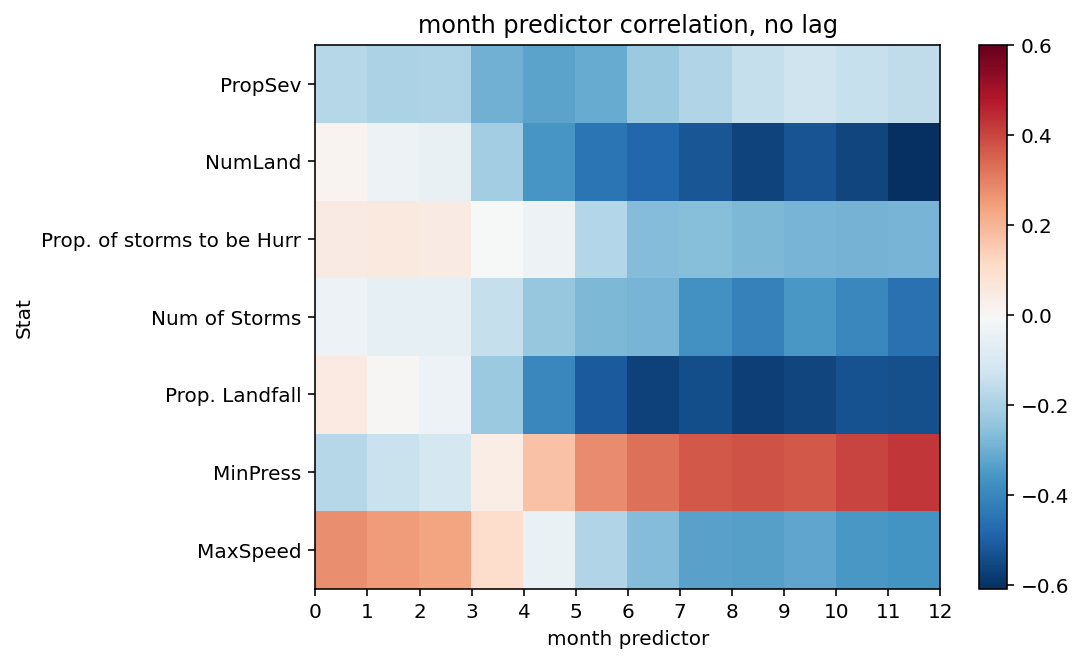

In [11]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, cc, vmax=0.6, vmin=cc.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms', 'Prop. of storms to be Hurr', 'NumLand', 'PropSev'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, no lag');

In [12]:
#Lag 0
preds = n34.n34.where(n34['T'].dt.month == 11, drop = True)[2:].values
N = len(preds)

y = resF['NumLand'].values

Nx = len(preds)
X = np.empty((Nx,2))
X[:,1] = preds
X[:,0] = 1

beta1 = inv(X.T@X)@X.T@y
yhat = X@beta1

Figure 2
--------------------------------------------------------------------------------------------------------------------------------

0.3118665265175184

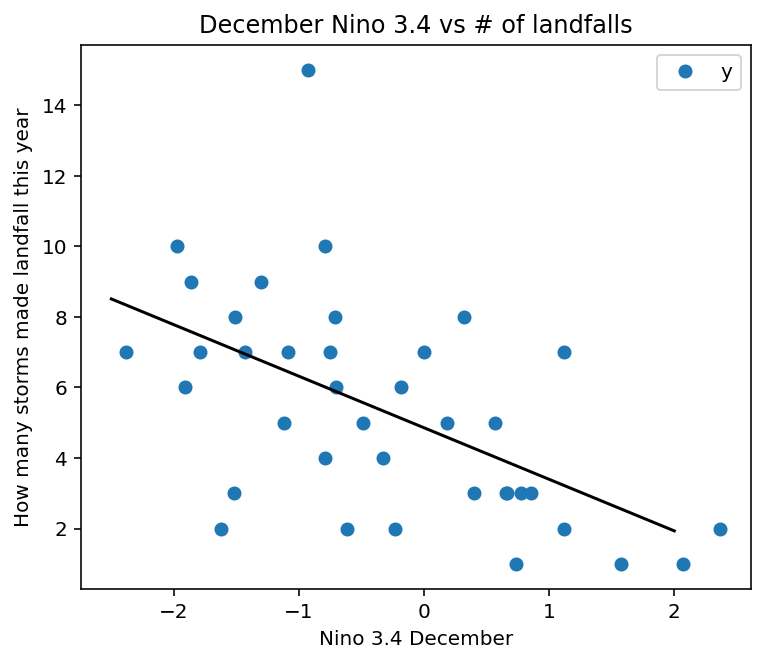

In [13]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds, y, 'o', label = 'y');

ax.set_xlabel('Nino 3.4 December')
ax.set_ylabel('How many storms made landfall this year');

x_line = np.linspace(-2.5, 2)
ax.plot(x_line, beta1[1]*x_line + beta1[0], color = 'k');
ax.set_title("December Nino 3.4 vs # of landfalls")

ax.legend();
rs = cor(preds,y)**2
rs

In [14]:
#Lag2

cc3 = np.empty((7,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc3[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['MaxSpeed'])
        cc3[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['MinPress'])
        cc3[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['Prop'])
        cc3[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['Count'])
        cc3[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['PropHurr'])
        cc3[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['NumLand'])
        cc3[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['PropSev'])
    else:
        cc3[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['MaxSpeed'])
        cc3[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['MinPress'])
        cc3[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['Prop'])
        cc3[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['Count'])
        cc3[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['PropHurr'])
        cc3[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['NumLand'])
        cc3[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['PropSev'])

Figure 3
---------------------------------------------------------------------------------------------------------------------

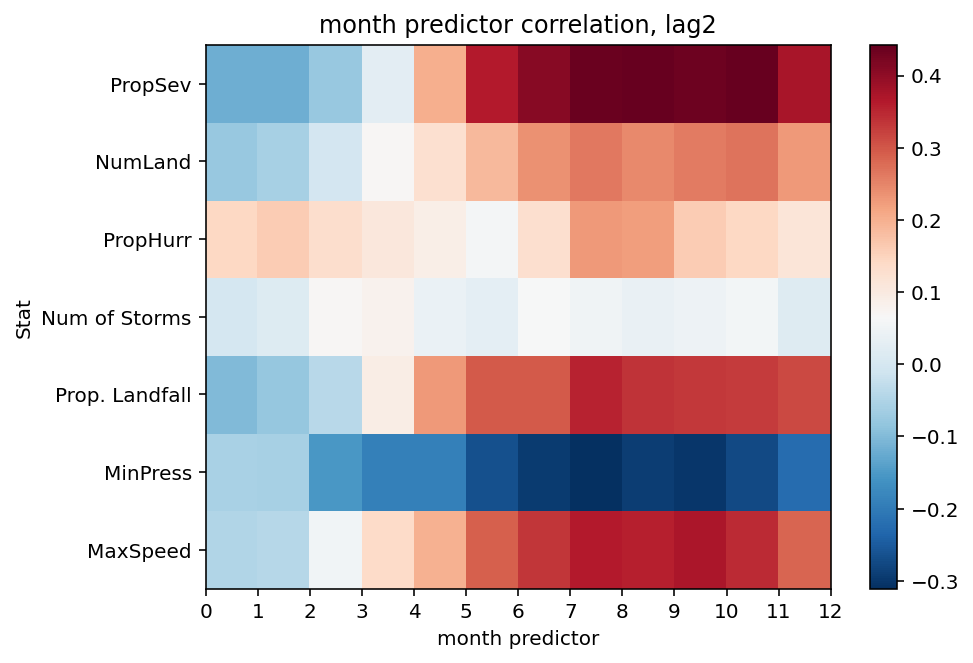

In [15]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, cc3, vmax=cc3.max(), vmin = cc3.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms', 'PropHurr','NumLand','PropSev'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, lag2');

In [16]:
#We only care about december now.
n34d = n34.n34.where(n34['T'].dt.month == 11, drop = True).values
n34d1 = np.roll(n34d, 1)
n34d2 = np.roll(n34d, 2)

In [17]:
#shift correlation
shift = np.empty((2,1))
shift[0,0] = cor(n34d, n34d1)
shift[1,0] = cor(n34d, n34d2)

Figure 4
------------------------------------------------------------------------------------------------------------------------------

-0.36234206925227996


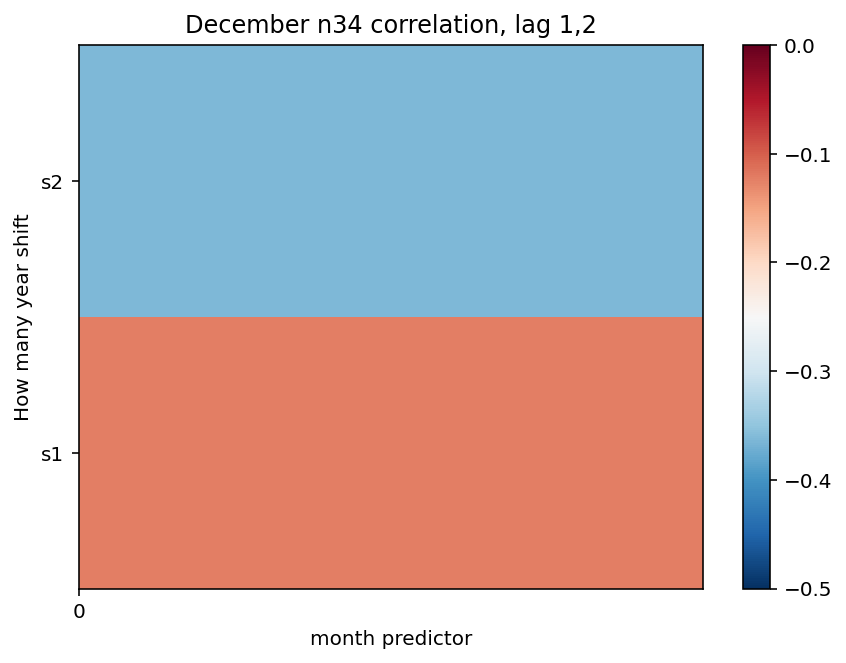

In [18]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 2), np.arange(0, 3) + 0.5, shift, vmax=0, vmin = -.5, cmap='RdBu_r')

ax.set_yticks(np.arange(1,3))
ax.set_yticklabels(['s1','s2'])
ax.set_xticks(np.arange(0,1))
plt.colorbar(g)
ax.set_ylabel('How many year shift')
ax.set_xlabel('month predictor')
ax.set_title('December n34 correlation, lag 1,2');
print(shift[1,0])

In [19]:
#Regress december n34
preds = n34d
N = len(preds)

y = n34d2

Nx = len(preds)
X = np.empty((Nx,2))
X[:,1] = preds
X[:,0] = 1

beta2 = inv(X.T@X)@X.T@y
yhat = X@beta2

Figure 5
------------------------------------------

0.13129177515002405

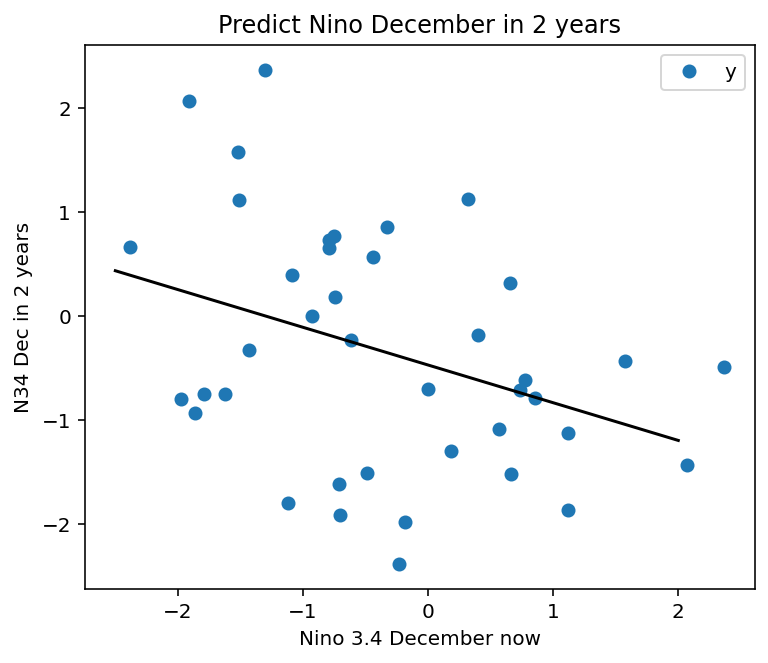

In [20]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds, y, 'o', label = 'y');

ax.set_xlabel('Nino 3.4 December now')
ax.set_ylabel('N34 Dec in 2 years');

x_line = np.linspace(-2.5, 2)
ax.plot(x_line, beta2[1]*x_line + beta2[0], color = 'k');
ax.set_title("Predict Nino December in 2 years")

ax.legend();
rs = cor(preds,y)**2
rs

Is there a better month to predict December?

In [21]:
mc = np.empty((2,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        mc[0, imonth] = cor(np.roll(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-1].values, 1), n34d)
        mc[1, imonth] = cor(np.roll(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-1].values, 2), n34d)
    else:
        mc[0, imonth] = cor(np.roll(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True).values, 1), n34d)
        mc[1, imonth] = cor(np.roll(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True).values, 2), n34d)

Figure 6
----------------

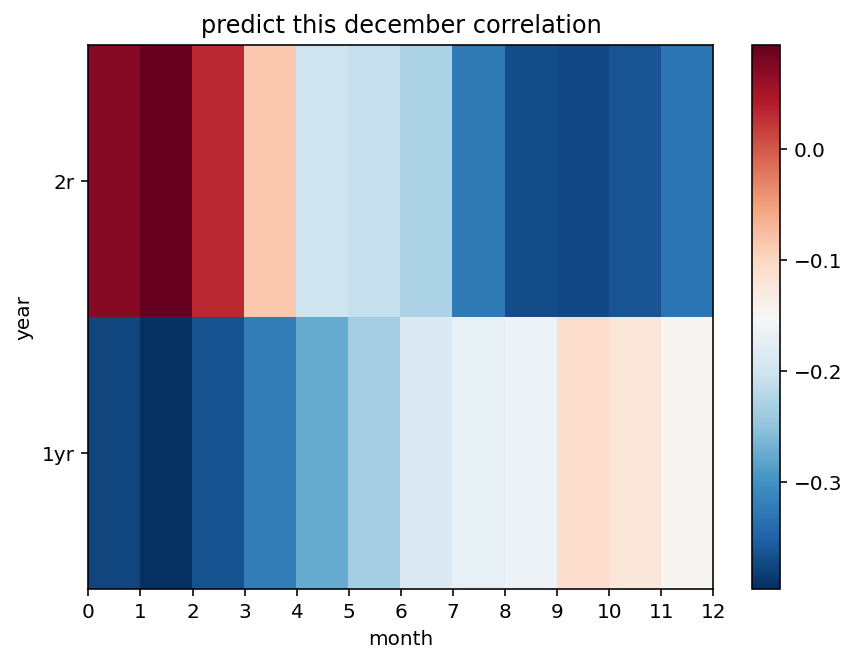

In [22]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 3) + 0.5, mc, vmax=mc.max(), vmin = mc.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,3))
ax.set_yticklabels(['1yr','2r'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('year')
ax.set_xlabel('month')
ax.set_title('predict this december correlation');

Ight Last February, I see you

In [23]:
#Now lets try w last feb
preds5 = n34.n34.where(n34['T'].dt.month == 1, drop = True)[1:-2].values
N = len(preds5)



y = n34d[2:]

Nx = len(preds5)
X = np.empty((Nx,2))
X[:,1] = preds5
X[:,0] = 1

betaF = inv(X.T@X)@X.T@y
yhat = X@betaF

Figure 7
--

0.13923329131960102

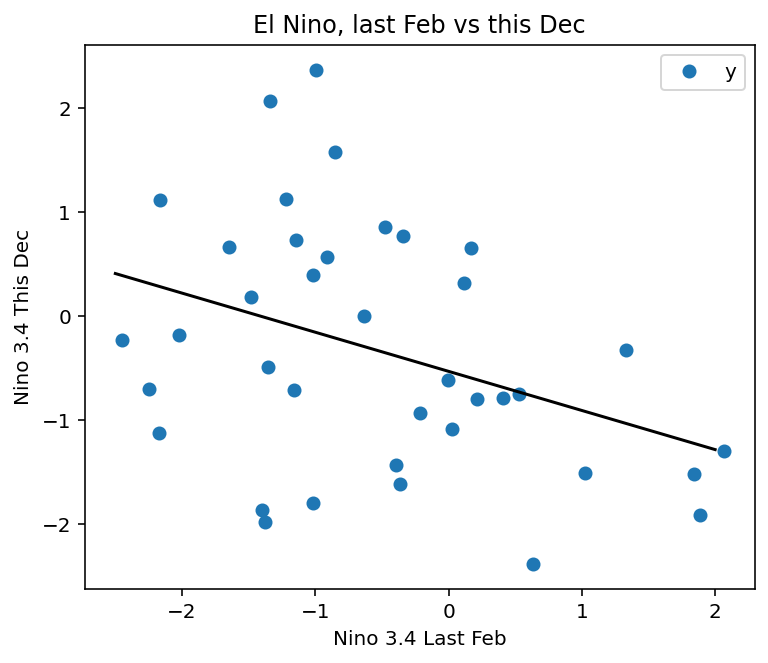

In [24]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds5, y, 'o', label = 'y');

ax.set_xlabel('Nino 3.4 Last Feb')
ax.set_ylabel('Nino 3.4 This Dec');

x_line = np.linspace(-2.5, 2)
ax.plot(x_line, betaF[1]*x_line + betaF[0], color = 'k');
ax.set_title("El Nino, last Feb vs this Dec")

ax.legend();
rs = cor(preds5,y)**2
rs

In [25]:
#beta2: LinReg for future Nino
#beta1: LinReg for this year's storms

#Regress december n34
y = resF['NumLand']

Figure 8
--

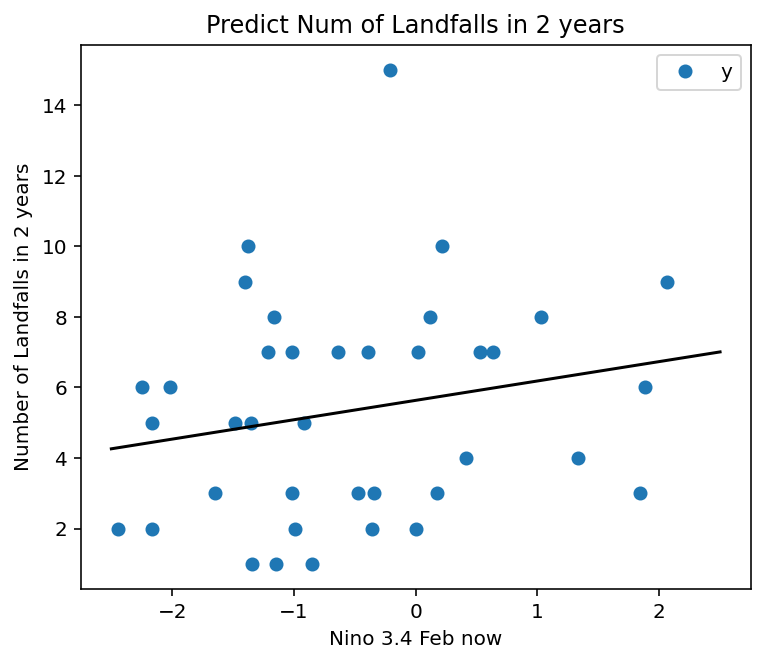

In [26]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds5, y, 'o', label = 'y');

ax.set_xlabel('Nino 3.4 Feb now')
ax.set_ylabel('Number of Landfalls in 2 years');

x_line = np.linspace(-2.5, 2.5)
ax.plot(x_line, beta1[1]*(betaF[1]*x_line + betaF[0]) + beta1[0], color = 'k');
ax.set_title("Predict Num of Landfalls in 2 years")

ax.legend();

resid3 = y - (beta1[1]*(betaF[1]*preds5 + betaF[0]) + beta1[0])

In [27]:
err = 0
for i in resid3:
    err += i**2
print("MSE: {}".format(err/len(resid3)))

MSE: 8.940818955340182


That one outlier is really grinding my gears.

In [28]:
beep = resF.drop([23], axis = 0)

In [29]:
newNino = n34.n34.where(n34['T'].dt.year != 2005, drop = True)
n34d2 = newNino.where(n34['T'].dt.month == 11, drop = True).values

In [30]:
#Now lets try w last feb
preds6 = newNino.where(newNino['T'].dt.month == 1, drop = True)[1:-2].values
N = len(preds6)



y = n34d2[2:]

Nx = len(preds6)
X = np.empty((Nx,2))
X[:,1] = preds6
X[:,0] = 1

betaG = inv(X.T@X)@X.T@y
yhat = X@betaG

0.1442607230178977

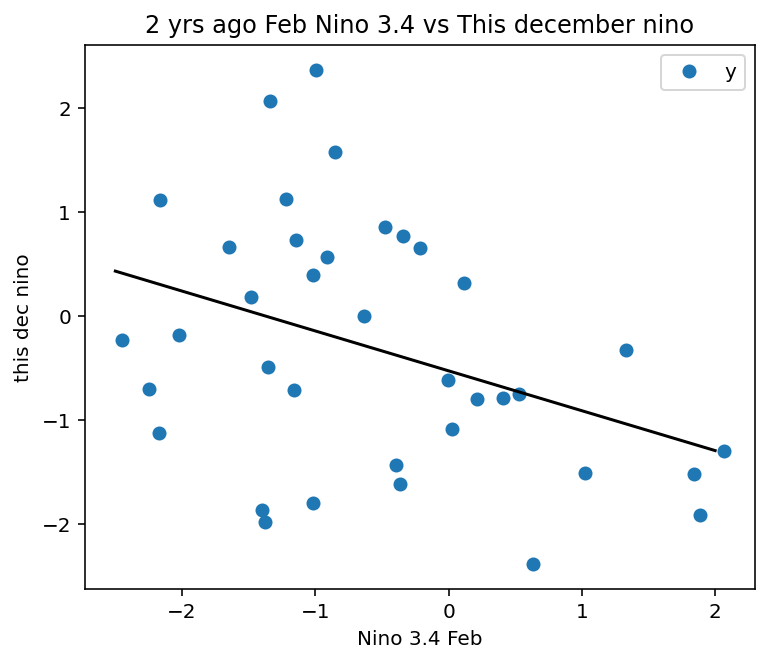

In [31]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds6, y, 'o', label = 'y');

ax.set_xlabel('Nino 3.4 Feb')
ax.set_ylabel('this dec nino');


x_line = np.linspace(-2.5, 2)

yhat = betaG[1]*x_line + betaG[0]
ax.plot(x_line, yhat, color = 'k');
ax.set_title("2 yrs ago Feb Nino 3.4 vs This december nino")

ax.legend();
rs = cor(preds6,y)**2
rs

In [32]:
#Lag 0
preds8 = n34d2[2:]
N = len(preds8)

y = beep['NumLand'].values

Nx = len(preds8)
X = np.empty((Nx,2))
X[:,1] = preds8
X[:,0] = 1

beta9 = inv(X.T@X)@X.T@y
yhat = X@beta9

0.365789155876331

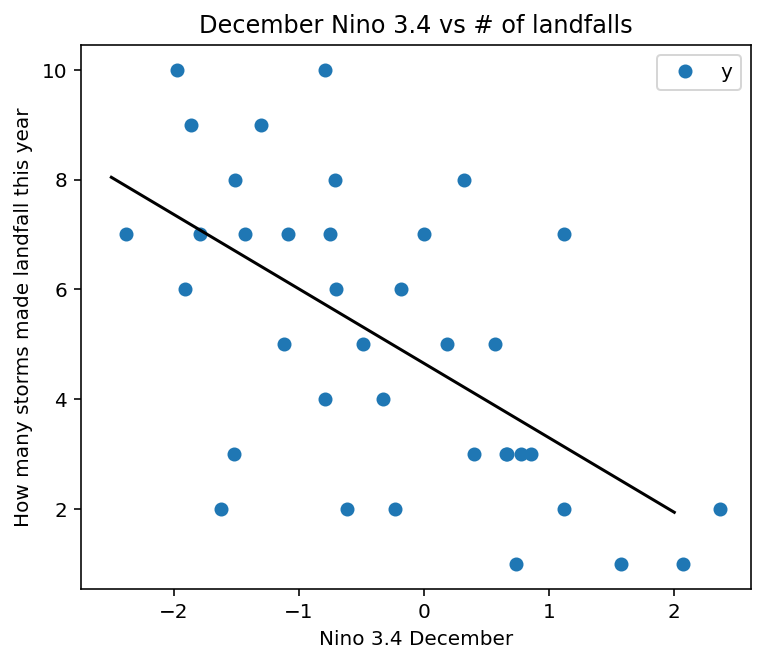

In [33]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds8, y, 'o', label = 'y');

ax.set_xlabel('Nino 3.4 December')
ax.set_ylabel('How many storms made landfall this year');

x_line = np.linspace(-2.5, 2)
ax.plot(x_line, beta9[1]*x_line + beta9[0], color = 'k');
ax.set_title("December Nino 3.4 vs # of landfalls")

ax.legend();
rs = cor(preds8,y)**2
rs

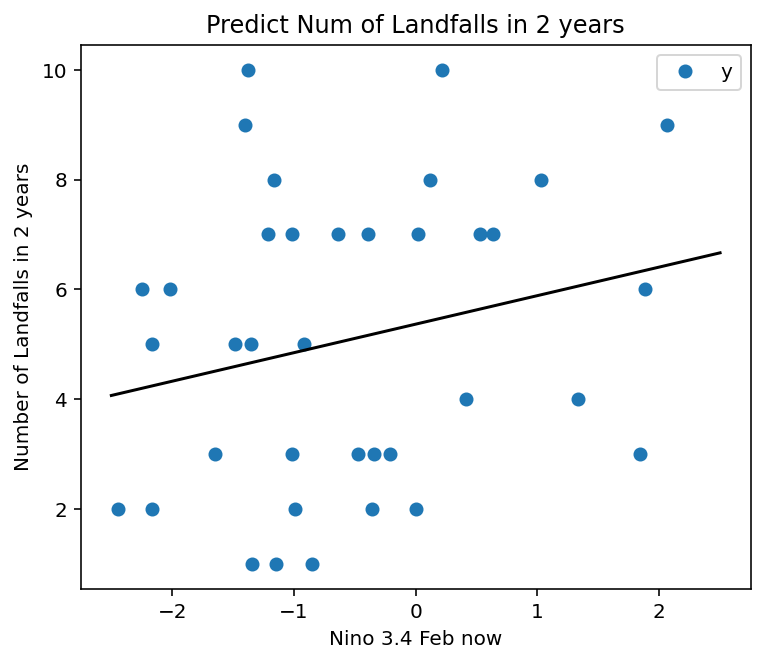

In [34]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds6, y, 'o', label = 'y');

ax.set_xlabel('Nino 3.4 Feb now')
ax.set_ylabel('Number of Landfalls in 2 years');

x_line = np.linspace(-2.5, 2.5)
ax.plot(x_line, beta9[1]*(betaG[1]*x_line + betaG[0]) + beta9[0], color = 'k');
ax.set_title("Predict Num of Landfalls in 2 years")

ax.legend();

resid4 = y - (beta9[1]*(betaG[1]*preds8 + betaG[0]) + beta9[0])

In [35]:
err = 0
for i in resid4:
    err += i**2
print("MSE: {}".format(err/len(resid4)))

MSE: 9.344148259711815


In [36]:
cor(preds6, y)**2

0.04832465889501868

In [37]:
resLabel = ['n34_Jan','n34_Feb','n34_Mar','n34_Apr','n34_May','n34_Jun','n34_Jul','n34_Aug','n34_Sep','n34_Oct','n34_Nov','n34_Dec']
statusLabel = ['Jan_Status','Feb_Status','Mar_Status','Apr_Status','May_Status','Jun_Status','Jul_Status','Aug_Status','Sep_Status','Oct_Status','Nov_Status','Dec_Status']

Figure 9
--

In [38]:
col = 'Count'

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


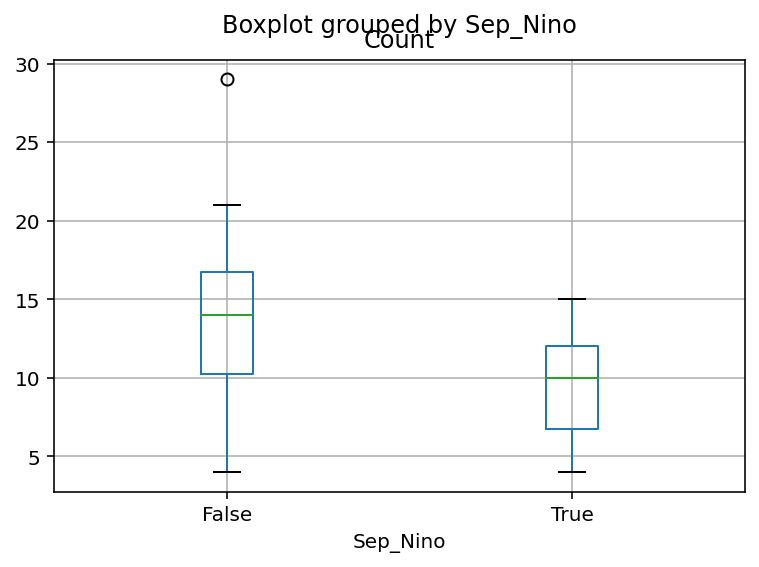

In [39]:
resF.boxplot(column = col, by = 'Sep_Nino')

In [40]:
resF['NumHurr'] = resF['PropHurr']*resF['Count']
resF['NumSev'] = resF['PropSev']*resF['Count']

In [42]:
print("Atlantic named storm average: {}".format(resF['Count'].mean()))
print("Atlantic hurricane average: {}".format(resF['NumHurr'].mean()))
print("Atlantic severe hurricane average: {}".format(resF['NumSev'].mean()))

Atlantic named storm average: 12.68421052631579
Atlantic hurricane average: 6.315789473684211
Atlantic severe hurricane average: 2.236842105263158


In [43]:
years = 0
Ncount=0
NHurr =0
NSev = 0
for i,j in resF.iterrows():
    if j['Sep_Nino'] == 1:
        Ncount += j['Count']
        NHurr += j['NumHurr']
        NSev += j['NumSev']
        years += 1
#     print(j['Year'])

In [44]:
print("Atlantic named storm average during Nino: {}".format(Ncount/years))
print("Atlantic hurricane average during Nino: {}".format(NHurr/years))
print("Atlantic severe hurricane average during Nino: {}".format(NSev/years))

Atlantic named storm average during Nino: 9.5
Atlantic hurricane average during Nino: 4.125
Atlantic severe hurricane average during Nino: 2.125
